## Langkah 1, Import Library

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input

## Langkah 2, Load Data Saham

In [53]:
# Unduh data dengan auto_adjust
df = yf.download('BBRI.JK',
                 start='2015-01-01',
                 end='2024-12-31',
                 auto_adjust=True)

# FLATTEN multi-index kolom menjadi satu level
df.columns = df.columns.get_level_values(0)

# Tampilkan data mentah
print("Data mentah:")
print(df.head())

# Ambil hanya kolom 'Close'
df = df[['Close']]
df.dropna(inplace=True)

# Tampilkan hasil akhir
print("\nData setelah dibersihkan:")
print(df.head())

[*********************100%***********************]  1 of 1 completed

Data mentah:
Price             Close         High          Low         Open     Volume
Date                                                                     
2015-01-02  1747.007202  1758.253913  1728.262551  1728.262551   49671357
2015-01-05  1739.509277  1754.505160  1735.760307  1739.509277   54526841
2015-01-06  1728.262817  1743.258501  1724.513846  1732.011587   71601886
2015-01-07  1765.751831  1765.751831  1735.760268  1739.509239  160783727
2015-01-08  1795.743408  1795.743408  1769.500816  1769.500816  161332636

Data setelah dibersihkan:
Price             Close
Date                   
2015-01-02  1747.007202
2015-01-05  1739.509277
2015-01-06  1728.262817
2015-01-07  1765.751831
2015-01-08  1795.743408


## Langkah 3, Normalisasi dan Windowing

In [55]:
# 1. Normalisasi harga penutupan (Close)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])  # harus 2D

In [57]:
# 2. Buat data window untuk LSTM
X = []
y = []
window_size = 60  # bisa diubah jadi 30, 90, dsb.

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])  # 60 nilai sebelumnya
    y.append(scaled_data[i, 0])                  # target: hari ke-61

# Ubah ke numpy array
X = np.array(X)
y = np.array(y)

# Ubah bentuk X agar sesuai input LSTM: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Tampilkan bentuk data
print(f'Bentuk input X: {X.shape}')  # (jumlah data, window, 1 fitur)
print(f'Bentuk target y: {y.shape}')

Bentuk input X: (2415, 60, 1)
Bentuk target y: (2415,)


## Langkah 4, Membuat & Melatih Model LSTM

In [59]:
# 1. Buat model LSTM
model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [61]:
# 2. Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [63]:
# 3. Latih model
history = model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0424
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0020
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016
Epoch 15/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0017
Epoc

## Langkah 5, Evaluasi dan Visualisasi Prediksi

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


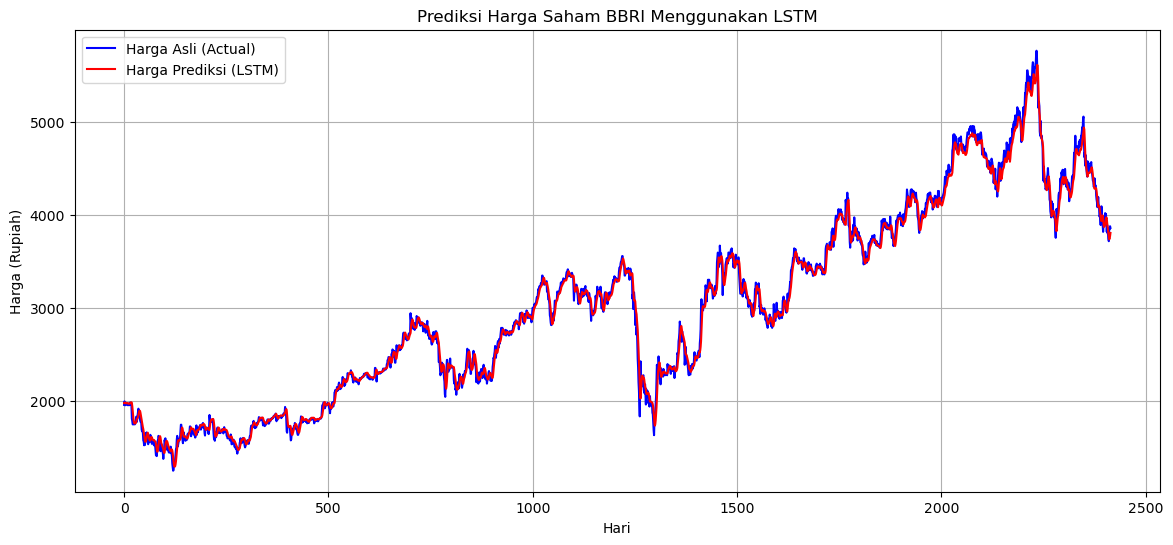

In [67]:
# Prediksi
predicted = model.predict(X)

# Balikkan ke skala asli
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Visualisasi
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, color='blue', label='Harga Asli (Actual)')
plt.plot(predicted_prices, color='red', label='Harga Prediksi (LSTM)')
plt.title('Prediksi Harga Saham BBRI Menggunakan LSTM')
plt.xlabel('Hari')
plt.ylabel('Harga (Rupiah)')
plt.legend()
plt.grid(True)
plt.show()

## Prediksi 30 Hari ke Depan

In [70]:
# 1. Ambil 60 hari terakhir dari data yang sudah dinormalisasi
last_window = scaled_data[-60:]  # scaled_data = hasil scaler.fit_transform(...)
future_input = last_window.reshape(1, 60, 1)  # sesuai shape LSTM

In [72]:
# 2. Simpan prediksi masa depan
future_predictions = []

In [74]:
# 3. Iterasi prediksi ke depan selama N hari
N = 30
for _ in range(N):
    # Prediksi hari berikutnya
    next_pred = model.predict(future_input, verbose=0)
    
    # Simpan hasil prediksi
    future_predictions.append(next_pred[0, 0])
    
    # Tambahkan hasil prediksi ke window input (geser ke kiri)
    future_input = np.append(future_input[:, 1:, :], [[[next_pred[0, 0]]]], axis=1)

In [76]:
# 4. Kembalikan ke skala asli
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

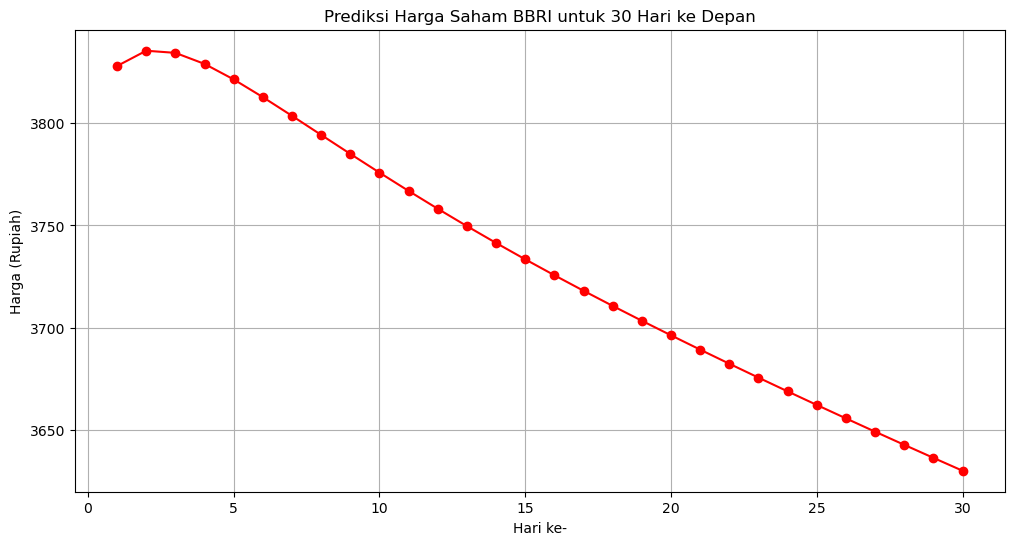

In [112]:
# 5. Visualisasikan hasilnya
plt.figure(figsize=(12, 6))
plt.plot(range(1, 31), future_prices, marker='o', linestyle='-', color='red')
plt.title("Prediksi Harga Saham BBRI untuk 30 Hari ke Depan")
plt.xlabel("Hari ke-")
plt.ylabel("Harga (Rupiah)")
plt.grid(True)
plt.show()

## Train-Test Split + Evaluasi di Data yang Belum Pernah Dilihat

### 1. Split Data 80:20

In [82]:
import numpy as np

# Jumlah data
data_len = len(scaled_data)

# 80% untuk train
train_size = int(data_len * 0.8)

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # minus 60 untuk sliding window

# Fungsi untuk buat window data
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Buat X_train, y_train dan X_test, y_test
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape X ke format (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1920, 60, 1), Test shape: (495, 60, 1)


### 2. Bangun dan Latih Ulang Model LSTM

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import Input

# Definisi model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile dan latih
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0295
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoc

### 3. Prediksi di Data Testing dan Evaluasi

In [90]:
# Prediksi
y_pred_scaled = model.predict(X_test)

# Inverse transform agar balik ke harga asli
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluasi RMSE & MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)

print(f"RMSE: {rmse:.2f} Rupiah")
print(f"MAE: {mae:.2f} Rupiah")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 127.70 Rupiah
MAE: 99.00 Rupiah


### 4. Visualisasi Prediksi vs Harga Aktual

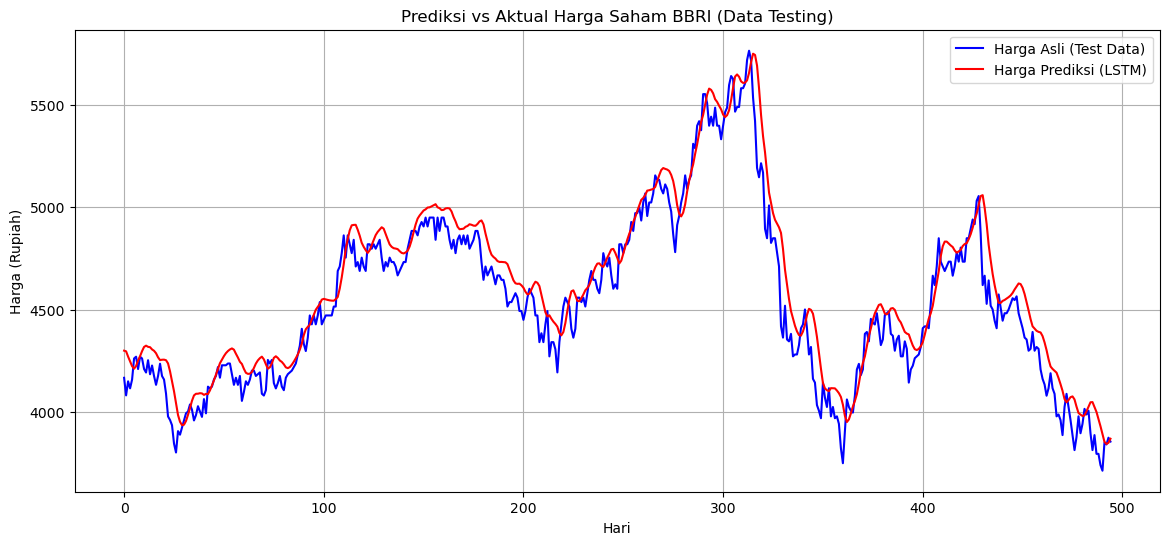

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label='Harga Asli (Test Data)', color='blue')
plt.plot(y_pred, label='Harga Prediksi (LSTM)', color='red')
plt.title('Prediksi vs Aktual Harga Saham BBRI (Data Testing)')
plt.xlabel('Hari')
plt.ylabel('Harga (Rupiah)')
plt.legend()
plt.grid(True)
plt.show()

## Sinyal Beli & Jual (berbasis moving average + LSTM)

### 1. Import Library

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2. Hitung Moving Averages (SMA 20 dan SMA 50)

In [100]:
# Gunakan harga asli dari dataframe
data_ma = df.copy()
data_ma['SMA_20'] = data_ma['Close'].rolling(window=20).mean()
data_ma['SMA_50'] = data_ma['Close'].rolling(window=50).mean()

### 3. Tambahkan Sinyal Beli & Jual

In [108]:
def generate_signals(data):
    buy_signal = []
    sell_signal = []
    position = False  # False = Tidak punya saham

    for i in range(len(data)):
        sma_20 = data['SMA_20'].iloc[i]
        sma_50 = data['SMA_50'].iloc[i]
        close = data['Close'].iloc[i]

        if pd.notna(sma_20) and pd.notna(sma_50):
            if sma_20 > sma_50:
                if not position:
                    buy_signal.append(close)
                    sell_signal.append(np.nan)
                    position = True
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
            elif sma_20 < sma_50:
                if position:
                    buy_signal.append(np.nan)
                    sell_signal.append(close)
                    position = False
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
            else:
                buy_signal.append(np.nan)
                sell_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    
    return buy_signal, sell_signal

### 4. Visualisasi Sinyal Beli dan Jual

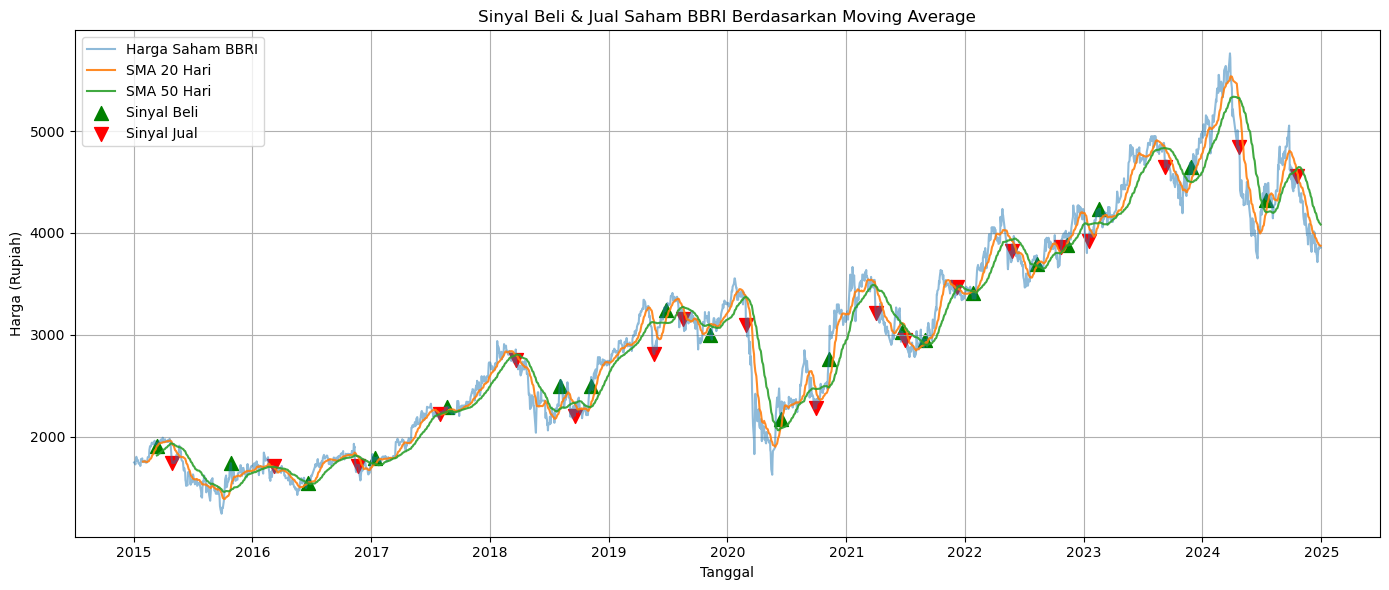

In [110]:
plt.figure(figsize=(14, 6))
plt.plot(data_ma['Close'], label='Harga Saham BBRI', alpha=0.5)
plt.plot(data_ma['SMA_20'], label='SMA 20 Hari', alpha=0.9)
plt.plot(data_ma['SMA_50'], label='SMA 50 Hari', alpha=0.9)
plt.scatter(data_ma.index, data_ma['Buy'], label='Sinyal Beli', marker='^', color='green', s=100)
plt.scatter(data_ma.index, data_ma['Sell'], label='Sinyal Jual', marker='v', color='red', s=100)
plt.title('Sinyal Beli & Jual Saham BBRI Berdasarkan Moving Average')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rupiah)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()